In [1]:
import numpy as np
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sb
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import edit_distance
from collections import Counter
import jellyfish
from wordcloud import WordCloud


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline


In [2]:
df_amazon = pd.read_csv('amazon_cells_labelled.txt', header=None, delimiter='\t', names=['txt', 'sentiment'])
df_amazon

,txt,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [3]:
# load the titanic dataset
df_titanic = pd.read_csv(r'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df_titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Solutions

### 1. What was the average age of the Titanic passengers?

In [4]:
df_titanic.Age.mean()

29.69911764705882

### 2. What is the survival rate of each passenger class in the Titanic? 

In [5]:
pd.crosstab(df_titanic.Pclass, df_titanic.Survived, normalize='index').iloc[:, 1]

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: 1, dtype: float64

In [6]:
# another way
df_titanic.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

### 3. Is the survival rate of young people (20y or less) higher than older people (30y+)?

In [7]:
young_survival_rate = df_titanic[df_titanic.Age<=20].Survived.mean()
old_survival_rate = df_titanic[df_titanic.Age>=30].Survived.mean()

young_survival_rate, old_survival_rate, young_survival_rate > old_survival_rate

(0.4581005586592179, 0.40606060606060607, True)

### 4. Use https://pypi.org/project/jellyfish/ to demontrate the edit distance between two words (you choose) before and after NYSIIS code is used

In [8]:
jellyfish.levenshtein_distance('antartica', 'america')

4

In [9]:
jellyfish.levenshtein_distance(jellyfish.nysiis('antartica'), jellyfish.nysiis('america'))

2

### 5. What are the two passenger names with the highest textual distance per CHARACTER?

In [10]:
%%time
# since edit distance is symmetrical we need to compare only once
# note that we use here the Jellyfish implementation of edit distance

max_distance = -1

for i in range(0, len(df_titanic)):
    for j in range(i+1, len(df_titanic)):
        current_distance = jellyfish.levenshtein_distance(df_titanic.Name.iloc[i], df_titanic.Name.iloc[j]) 
        if current_distance > max_distance:
            max_distance_index_i = i
            max_distance_index_j = j
            max_distance = current_distance

df_titanic.Name.iloc[max_distance_index_i], df_titanic.Name.iloc[max_distance_index_j], max_distance

CPU times: total: 9.58 s
Wall time: 9.58 s


('Rugg, Miss. Emily',
 'Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)',
 75)

### 6. What are the two passenger names with the lowest textual distance per WORD?

In [11]:
# prepare list of words for each name
df_titanic['list_words_for_name'] = df_titanic.Name.apply(lambda x : re.split('\W+', str(x)))
df_titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,list_words_for_name
306,307,1,1,"Fleming, Miss. Margaret",female,NaN,0,0,17421,110.8833,NaN,C,"[Fleming, Miss, Margaret]"
758,759,0,3,"Theobald, Mr. Thomas Leonard",male,34.0,0,0,363294,8.0500,NaN,S,"[Theobald, Mr, Thomas, Leonard]"
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S,"[Sloper, Mr, William, Thompson]"
384,385,0,3,"Plotcharsky, Mr. Vasil",male,NaN,0,0,349227,7.8958,NaN,S,"[Plotcharsky, Mr, Vasil]"
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,"[Foo, Mr, Choong]"


In [12]:
%%time
# since edit distance is symmetrical we need to compare only once
# note that we use here the NLTK implementation of edit distance

min_distance = max(df_titanic.list_words_for_name.apply(len))

for i in range(0, len(df_titanic)):
    for j in range(i+1, len(df_titanic)):
        current_distance = edit_distance(df_titanic['list_words_for_name'].iloc[i], df_titanic['list_words_for_name'].iloc[j]) 
        if current_distance < min_distance:
            min_distance_index_i = i
            min_distance_index_j = j
            min_distance = current_distance

df_titanic.Name.iloc[min_distance_index_i], df_titanic.Name.iloc[min_distance_index_j], min_distance

CPU times: total: 17 s
Wall time: 17 s


('Allen, Mr. William Henry', 'Saundercock, Mr. William Henry', 1)

### 7. Build two wordclouds, one for good amazon reviews and one for bad reviews

In [13]:
concatenated_docs_happy = ', '.join(list(df_amazon[df_amazon['sentiment'] == 1].txt.values))
concatenated_docs_sad = ', '.join(list(df_amazon[df_amazon['sentiment'] == 0].txt.values))
list_of_docs = [concatenated_docs_happy, concatenated_docs_sad]

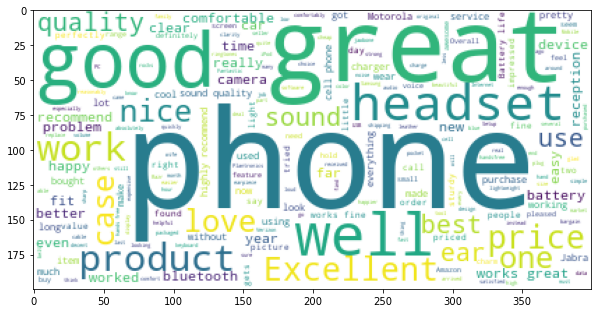

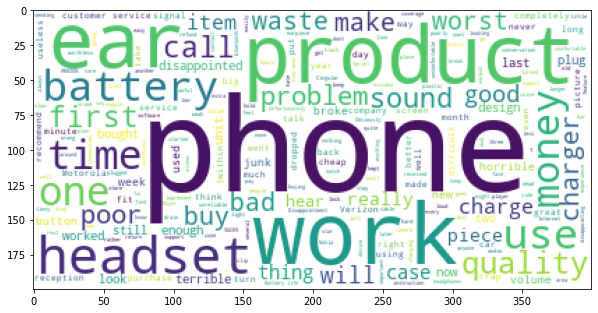

In [14]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
for doc in list_of_docs:
    wordcloud.generate(doc)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.show()

### 8. Build a classifier for Amazon reviews sentiment prediction that works on:
### (1) only bigrams, (2) only unigrams, (3) both. Who is best?

In [15]:
# I did only for (3)...
stop_words_set = set(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(stop_words = stop_words_set, ngram_range = (1, 2), binary = False, tokenizer = lambda s:s.split(' '), max_features = 500, min_df = 3)

tf_idf_mat = tfidf_vectorizer.fit_transform(df_amazon['txt'])
tf_idf_names = tfidf_vectorizer.get_feature_names_out()   


In [16]:
tfidf_df = pd.DataFrame(tf_idf_mat.toarray(), columns = tf_idf_names)
tfidf_df

,&,",",-,--,2,2 years,3,5,510,able,...,works great.,works well.,worst,worst phone,worth,would,would highly,would recommend,year,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df_amazon['sentiment'], test_size=0.2, random_state=42)

In [18]:
%%time
classifier = LogisticRegression() 

model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

CPU times: total: 109 ms
Wall time: 28.6 ms


In [19]:
print(classification_report(y_test, prediction))

confusion_matrix(y_test, prediction)

              precision    recall  f1-score   support

           0       0.72      0.86      0.78        93
           1       0.85      0.71      0.78       107

    accuracy                           0.78       200
   macro avg       0.79      0.79      0.78       200
weighted avg       0.79      0.78      0.78       200



array([[80, 13],
       [31, 76]], dtype=int64)

In [20]:
# feature imporatance for LR:
pd.DataFrame(zip(tfidf_df.columns, model.coef_[0]), columns=['word', 'weight']).sort_values(by='weight')

,word,weight
430,waste,-1.404520
316,poor,-1.324448
152,first,-1.243061
454,worst,-1.188362
31,bad,-1.167919
...,...,...
132,excellent,1.741556
275,nice,1.900631
36,best,1.972509
447,works,2.432412


In [21]:
# A simple Feed Forward Neural Network
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [30]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               59264     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 42)                2730      
                                                                 
 dense_7 (Dense)             (None, 1)                 43        
                                                                 
Total params: 70,293
Trainable params: 70,293
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6901 - accuracy: 0.5188
Epoch 2/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6587 - accuracy: 0.7025
Epoch 3/20
25/25 [==============================] - 0s 1ms/step - loss: 0.5295 - accuracy: 0.8425
Epoch 4/20
25/25 [==============================] - 0s 1ms/step - loss: 0.3110 - accuracy: 0.8925
Epoch 5/20
25/25 [==============================] - 0s 1ms/step - loss: 0.1989 - accuracy: 0.9137
Epoch 6/20
25/25 [==============================] - 0s 1ms/step - loss: 0.1392 - accuracy: 0.9362
Epoch 7/20
25/25 [==============================] - 0s 1ms/step - loss: 0.1069 - accuracy: 0.9525
Epoch 8/20
25/25 [==============================] - 0s 1ms/step - loss: 0.0955 - accuracy: 0.9475
Epoch 9/20
25/25 [==============================] - 0s 1ms/step - loss: 0.0842 - accuracy: 0.9575
Epoch 10/20
25/25 [==============================] - 0s 1ms/step - loss: 0.0838 - accuracy: 0.9500
Epoch 11/20
25/25 [

In [34]:
val_loss, val_acc = model.evaluate(X_test, y_test)
val_acc, val_loss

7/7 [==============================] - 0s 2ms/step - loss: 0.9773 - accuracy: 0.7850


(0.7850000262260437, 0.9772752523422241)